In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from PIL import Image, ImageDraw
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor
from transformers import DetrForObjectDetection
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

2024-03-29 01:02:53.816821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 01:02:53.816920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 01:02:53.993791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install pycocotools --quiet

In [3]:
!pip install -q coco-eval

### Prepare datasets

In [4]:
# Class for reforming datasets into coco detection format
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=False, val= False, test = False):
        if train:
            ann_file = os.path.join(img_folder, "train_annot.json")#_annotations.coco.json
          #print(ann_file)
        elif val:
            ann_file = os.path.join(img_folder, "val_annot.json")
        elif test:
            ann_file = os.path.join(img_folder, "test_annot.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


In [5]:
# Load data
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train = CocoDetection(img_folder='/kaggle/input/trash-object-detection-dataset/trash.v33-allclass.coco.zip (Unzipped Files)/train', processor=processor, train=True)
val = CocoDetection(img_folder='/kaggle/input/trash-object-detection-dataset/trash.v33-allclass.coco.zip (Unzipped Files)/train', processor=processor, val=True)
test = CocoDetection(img_folder='/kaggle/input/trash-object-detection-dataset/trash.v33-allclass.coco.zip (Unzipped Files)/valid', processor=processor, test=True)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


In [6]:
print("Number of training examples:", len(train))
print("Number of validation examples:", len(val))
print("Number of test examples:", len(test))

Number of training examples: 11076
Number of validation examples: 2766
Number of test examples: 2750


Image n°6265


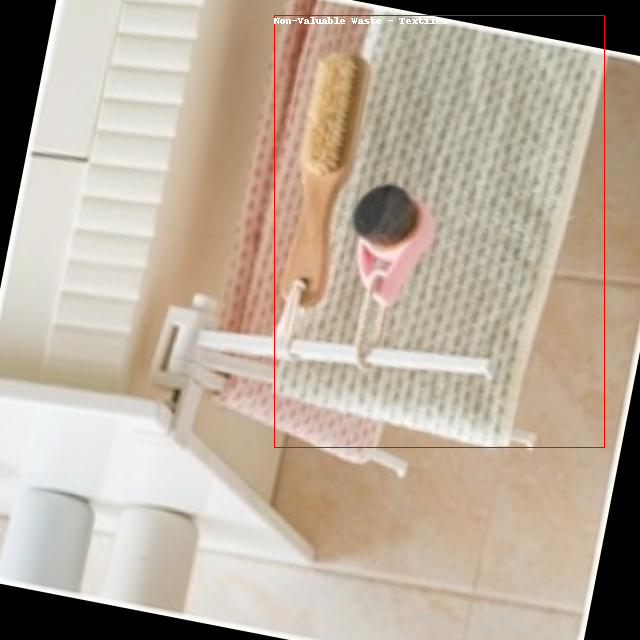

In [6]:
# Visualizing images
image_ids = train.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/kaggle/input/trash-object-detection-dataset/trash.v33-allclass.coco.zip (Unzipped Files)/train', image['file_name']))

annotations = train.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
    draw.text((x, y), id2label[class_idx], fill='white')

image

In [7]:
# Create Dataloaders
def collate_fn(batch):
    #print(batch)
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels

    return batch

train_dataloader = DataLoader(train, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers=3)
val_dataloader = DataLoader(val, collate_fn=collate_fn, batch_size=2, num_workers=3)
test_dataloader = DataLoader(test, collate_fn=collate_fn, batch_size=2, num_workers=3)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
batch.keys()

In [ ]:
pixel_values, target = train[0]
print(pixel_values.shape)
print(target)

### Base DETR

In [8]:
model_pretrained = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretrained = model_pretrained.to(device)

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Finetuning DETR

In [9]:
class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                         revision="no_timm",
                                                         num_labels=len(id2label),
                                                         ignore_mismatched_sizes=True)
        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict



    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss, prog_bar=True)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, prog_bar=True)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [ ]:
# # Start tensorboard.
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [ ]:
# model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
# outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])
# print(batch['pixel_values'].size())
# print(outputs.logits.shape)

In [ ]:
# Instantiate the EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='validation_loss',  # Metric to monitor for early stopping
    patience=1,                  # Number of epochs with no improvement after which training will be stopped
    verbose=True,                # Print early stopping updates
    mode='min'                   # 'min' or 'max': minimize or maximize the monitored metric
)

# Train model
trainer = Trainer(max_epochs=5, gradient_clip_val=0.1, callbacks=[early_stop_callback])
trainer.fit(model)

In [ ]:
# Save the model to a file
torch.save(model.state_dict(), '/kaggle/working/DETR_finetuned.pth')

In [14]:
# Reload the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(torch.load('/kaggle/input/detr-finetuned/pytorch/1/1/DETR_finetuned.pth'))
model.to(device)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([16, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): ResNetBackbone(
            (embedder): ResNetEmbeddings(
              (embedder): ResNetConvLayer(
                (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                (normalization): DetrFrozenBatchNorm2d()
                (activation): ReLU()
              )
              (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            )
            (encoder): ResNetEncoder(
              (stages): ModuleList(
                (0): ResNetStage(
                  (layers): Sequential(
                    (0): ResNetBottleNeckLayer(
                      (shortcut): ResNetShortCut(
                        (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                        (normalization): DetrFrozenBatchNorm2d

### Post Processing and Evaluation

In [9]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [15]:
def evaluate(data, data_loader, model):
    # initialize evaluator with ground truth (gt)
    evaluator = CocoEvaluator(coco_gt=data.coco, iou_types=["bbox"])

    print("Running evaluation...")
    for idx, batch in enumerate(tqdm(data_loader)):
        # get the inputs
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

        # forward pass
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        # turn into a list of dictionaries (one item for each example in the batch)
        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes, threshold=0)

        # provide to metric
        # metric expects a list of dictionaries, each item
        # containing image_id, category_id, bbox and score keys
        predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
        predictions = prepare_for_coco_detection(predictions)
        evaluator.update(predictions)

    evaluator.synchronize_between_processes()
    evaluator.accumulate()
    evaluator.summarize()
    
# Evaluating finetuned model on validation data  
evaluate(val, val_dataloader, model)

Running evaluation...


  0%|          | 0/1383 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=2.89s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.704
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [11]:
# Evaluating base model on validation data  
evaluate(val, val_dataloader, model_pretrained)

Running evaluation...


  0%|          | 0/1383 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=1.45s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [62]:
# Evaluating finetuned model on test data  
evaluate(test, test_dataloader, model)

Running evaluation...


  0%|          | 0/1375 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=2.99s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.157
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [12]:
# Evaluating base model on test data  
evaluate(test, test_dataloader, model_pretrained)

Running evaluation...


  0%|          | 0/1375 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=1.49s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

### Inference with Finetuned DETR

In [57]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{list(val.coco.cats.values())[label]["name"]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

### Inference on test data

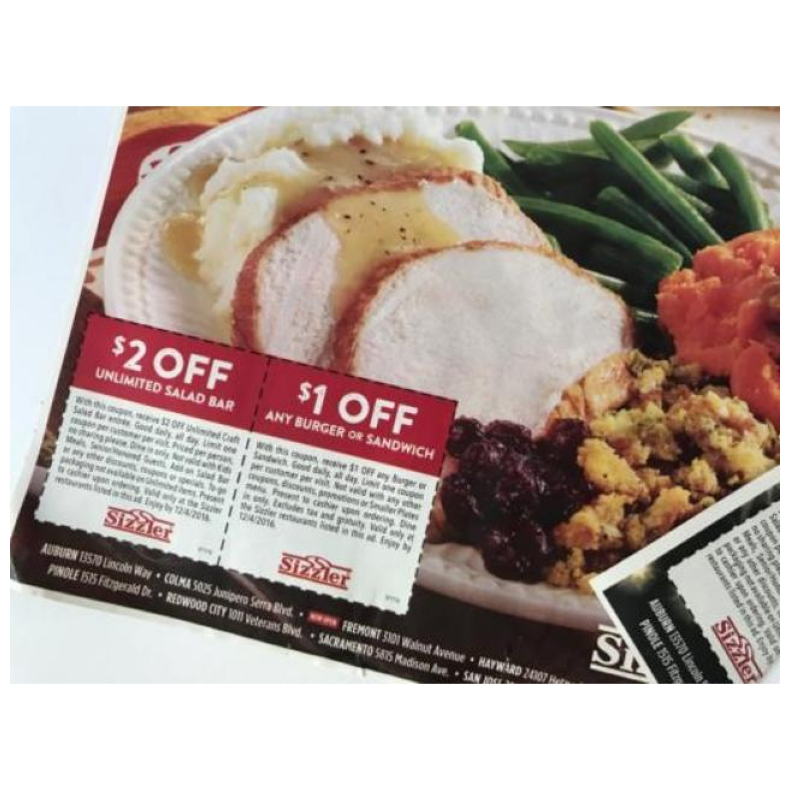

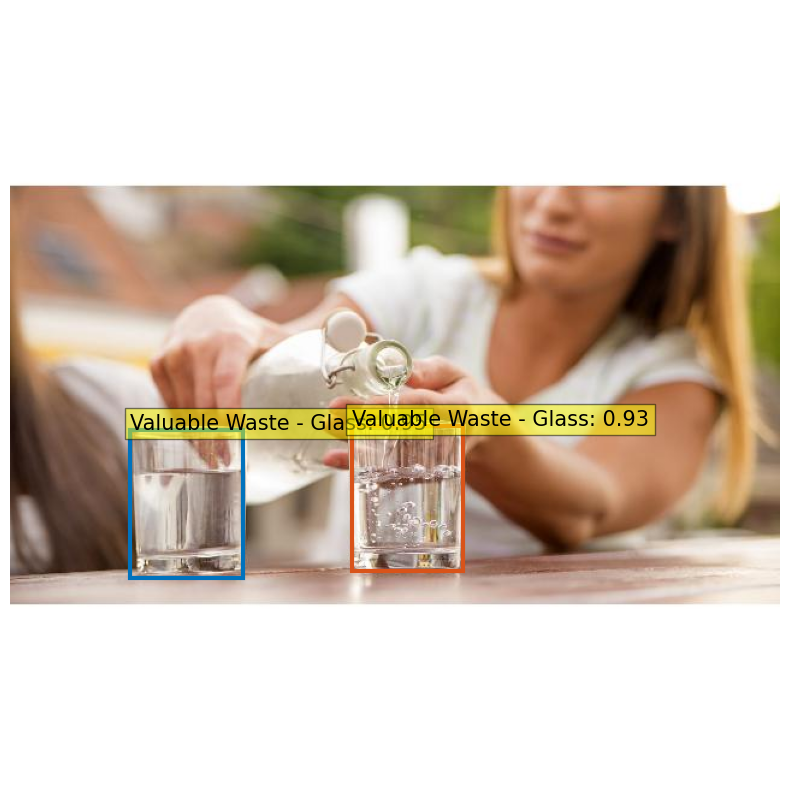

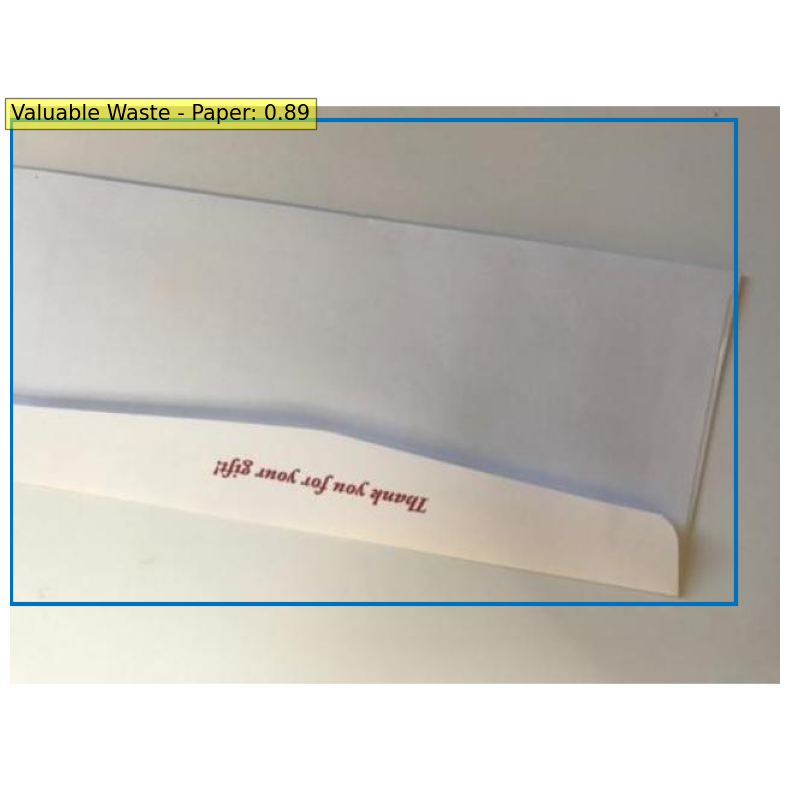

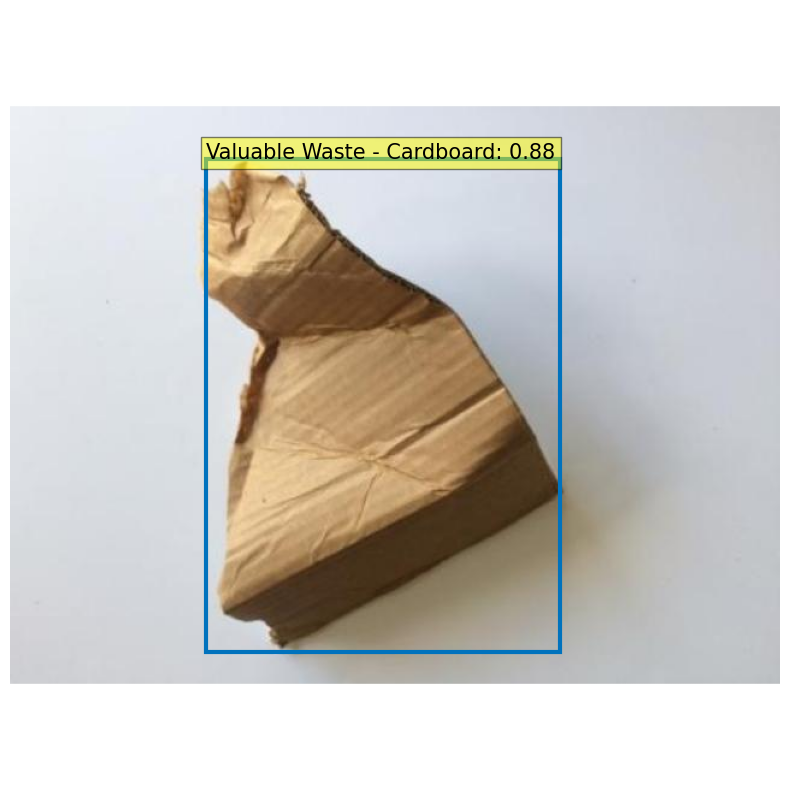

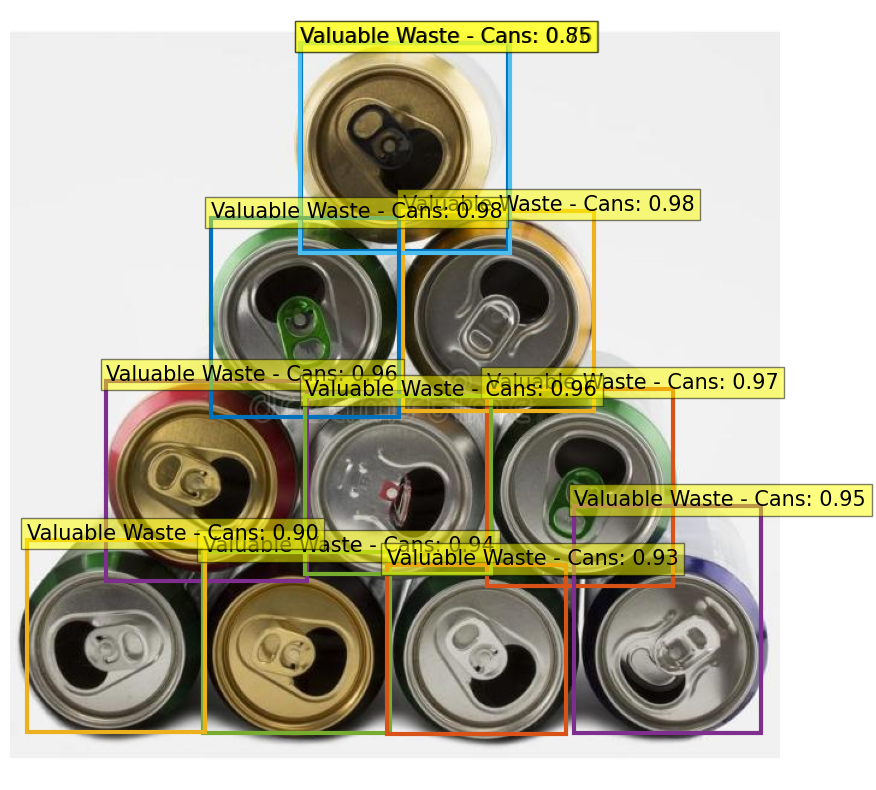

In [61]:
# Inference on validation data
for i in np.random.randint(0, len(val), 5):
    pixel_values, target = val[i]
    pixel_values = pixel_values.unsqueeze(0).to(device)
    with torch.no_grad():
  # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=None)
    # load image based on ID
    image_id = target['image_id'].item()
    image = val.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join('/kaggle/input/trash-object-detection-dataset/trash.v33-allclass.coco.zip (Unzipped Files)/train', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.75)
    results = postprocessed_outputs[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])

### Inference on test data

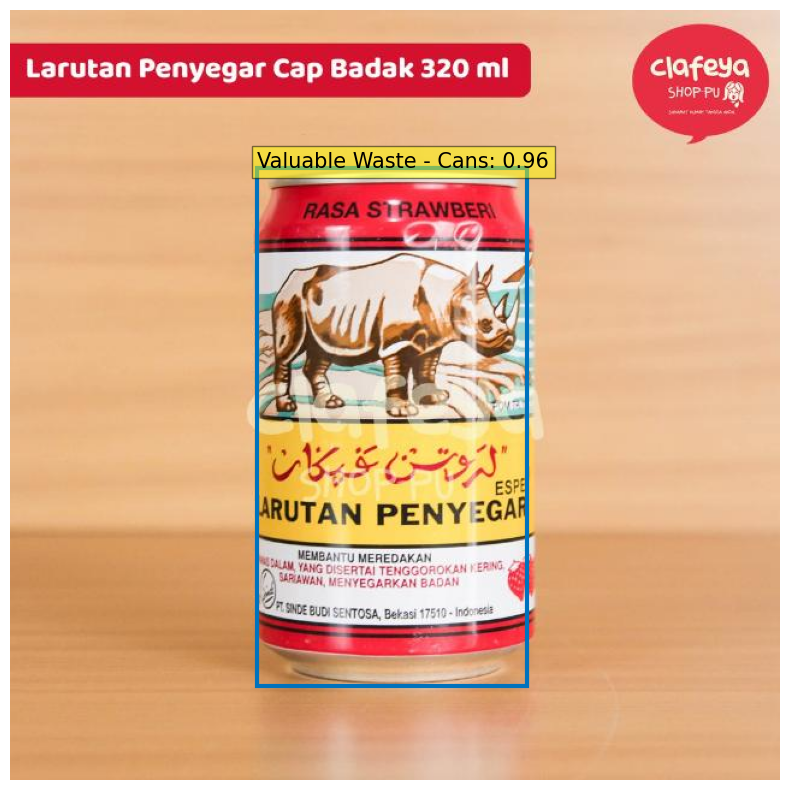

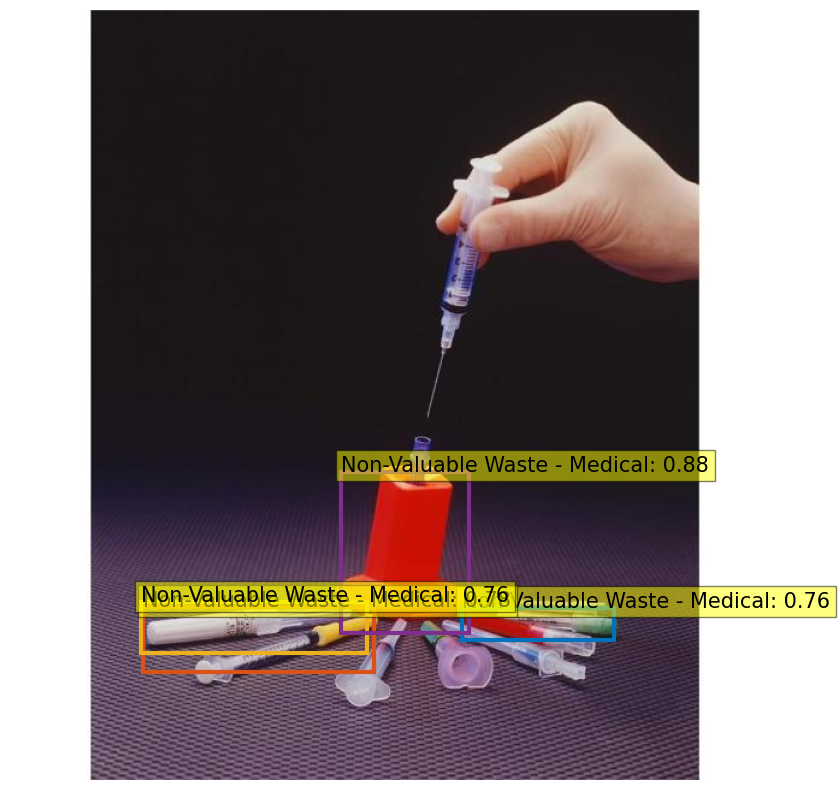

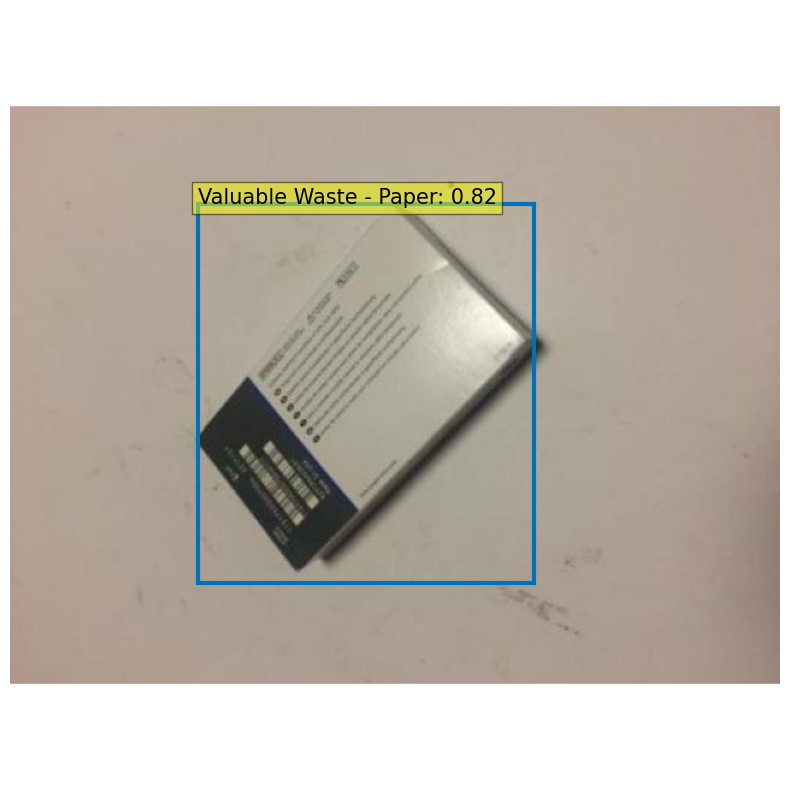

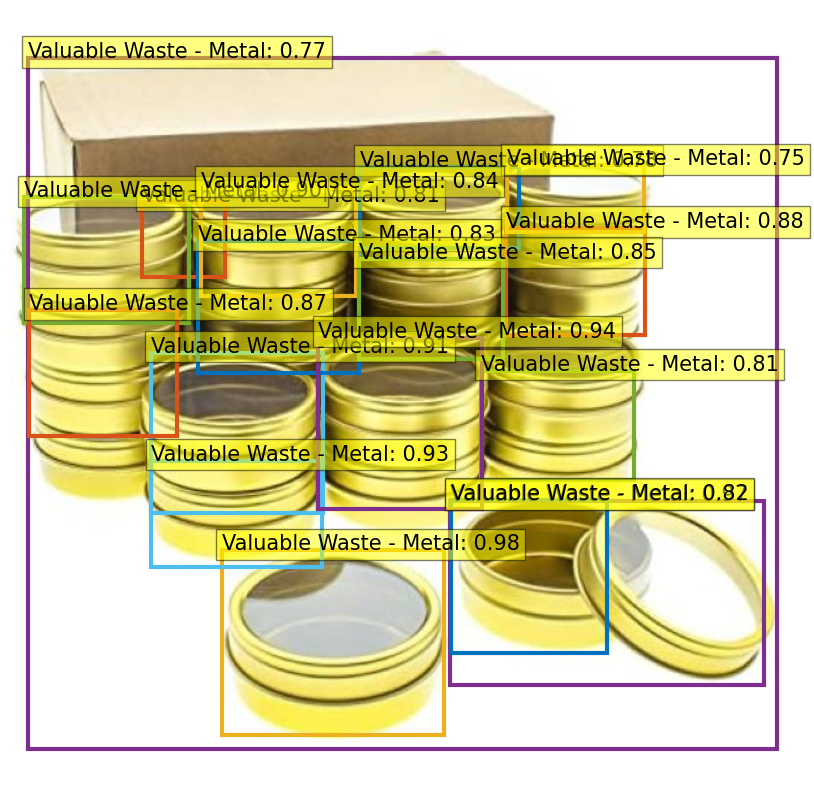

In [ ]:
# Inference on test data
for i in np.random.randint(0, len(test), 5):
    pixel_values, target = test[i]
    pixel_values = pixel_values.unsqueeze(0).to(device)
    with torch.no_grad():
  # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=None)
    # load image based on ID
    image_id = target['image_id'].item()
    image = test.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join('/kaggle/input/trash-object-detection-dataset/trash.v33-allclass.coco.zip (Unzipped Files)/valid', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.75)
    results = postprocessed_outputs[0]
    plot_results(image, results['scores'], results['labels'], results['boxes'])